# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("C:/NHS maternity data/discharge files processed/healthcare-dataset-stroke-data.csv")


#Show dataset has loaded, search for missing values
print(data.head())
print("\nMissing values per column:")
print(data.isnull().sum())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing values per column:
id                     0
gen

In [35]:
# Impute missing values in 'bmi' with mean
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
print(data.isnull().sum())


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [36]:
# Encode categorical variables
le = LabelEncoder()
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for feature in categorical_features:
    data[feature] = le.fit_transform(data[feature])


In [37]:
# Drop 'id' column
data.drop('id', axis=1, inplace=True)

In [38]:
# Define features and target variable
X = data.drop('stroke', axis=1)
y = data['stroke']


In [39]:
# Handle imbalanced dataset using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [40]:
# Split data into training, validation, and testing sets (60% train, 20% validation, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)


In [41]:
# Feature Scaling
scaler = StandardScaler()
numerical_features = ['age', 'avg_glucose_level', 'bmi']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [42]:
# Initialize models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [43]:
# Hyperparameter tuning for Random Forest using Stratified K-Fold Cross-Validation
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
print("\nBest parameters for Random Forest:")
print(grid_rf.best_params_)


Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [44]:
# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_gb.fit(X_train, y_train)
print("\nBest parameters for Gradient Boosting:")
print(grid_gb.best_params_)


Best parameters for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [45]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
    }
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
print("\nBest parameters for XGBoost:")
print(grid_xgb.best_params_)


Best parameters for XGBoost:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


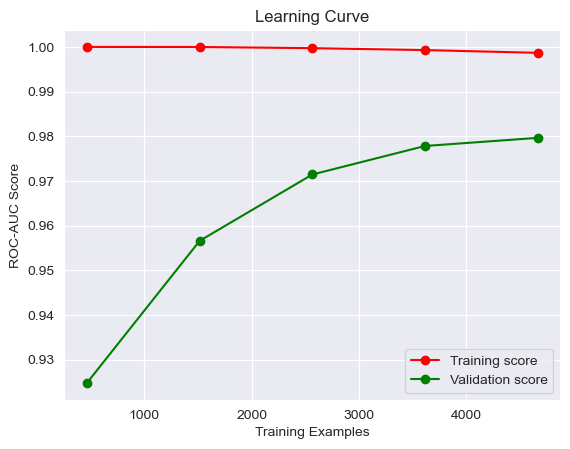

In [46]:
# Ensemble Model using Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('gb', grid_gb.best_estimator_),
        ('xgb', grid_xgb.best_estimator_)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=voting_clf,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('ROC-AUC Score')
plt.legend(loc='best')
plt.show()

In [47]:
y_val_pred = voting_clf.predict(X_val)
y_val_proba = voting_clf.predict_proba(X_val)[:,1]

In [48]:
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       973
           1       0.91      0.95      0.93       972

    accuracy                           0.92      1945
   macro avg       0.92      0.92      0.92      1945
weighted avg       0.92      0.92      0.92      1945



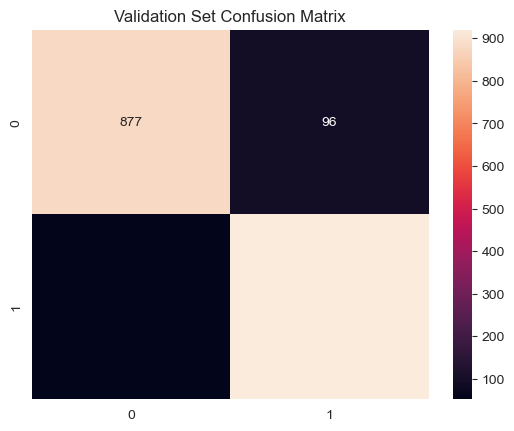

In [49]:
# Confusion Matrix
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d')
plt.title('Validation Set Confusion Matrix')
plt.show()

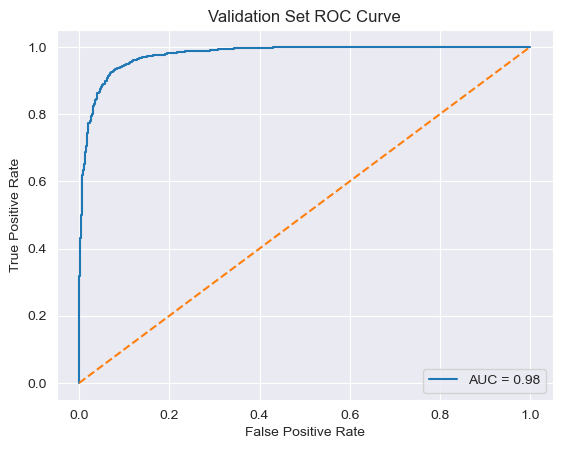

In [50]:
# ROC-AUC Curve
roc_auc_val = roc_auc_score(y_val, y_val_proba)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)
plt.plot(fpr_val, tpr_val, label='AUC = %.2f' % roc_auc_val)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Validation Set ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [51]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
average_precision = average_precision_score(y_val, y_val_proba)
plt.plot(recall, precision, label='Average Precision = %.2f' % average_precision)
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

NameError: name 'precision_recall_curve' is not defined

In [ ]:
# Get feature importances from the Random Forest model
feature_importances = grid_rf.best_estimator_.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

In [ ]:
y_test_pred = voting_clf.predict(X_test)
y_test_proba = voting_clf.predict_proba(X_test)[:,1]
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.title('Test Set Confusion Matrix')
plt.show()

In [ ]:
roc_auc_test = roc_auc_score(y_test, y_test_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.plot(fpr_test, tpr_test, label='AUC = %.2f' % roc_auc_test)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Test Set ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, y_test_proba)
average_precision_test = average_precision_score(y_test, y_test_proba)
plt.plot(recall_test, precision_test, label='Average Precision = %.2f' % average_precision_test)
plt.title('Test Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()